## HouseKeeping

In [2]:
% load_ext autoreload
% autoreload 2
import pandas as pd
from BioAnalysis import BioAnalysis
import numpy as np
from tqdm import tqdm, trange
import sys
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt
import operator 
from collections import OrderedDict
from sklearn.linear_model import RANSACRegressor
from scipy.stats import fisher_exact
from IPython.display import HTML, display
import csv
from sklearn.linear_model import LinearRegression

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
db = pd.read_csv('../Amrita_29feb/features.csv')
# lets subtract the bgmean from the intensity

columns = list(db.columns)

# intensities = [s for s in columns if "Intensity_MC" in s]
# bkgds = [s for s in columns if "Bkgd" in s]

# for a,b in zip(intensities, bkgds):  
#     db[a] = db[a] - db[b]
    
analysis = BioAnalysis('../Amrita_29feb/')
points = analysis.points


filtered = analysis.getFilteredIndices()

filtered_db = pd.DataFrame(columns=db.columns)
for idx,row in enumerate(tqdm(filtered)):
    filtered_db = filtered_db.append(db[(db.Class == int(row[0])) & (db["Object Number"]==int(row[1]))])
    filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch02')] = points[idx, 0]
    filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch07')] = points[idx, 1]
    filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch11')] = points[idx, 2]
    try:
        filtered_db.iloc[-1, filtered_db.columns.get_loc('Intensity_MC_Ch04')] = points[idx, 3]
    except:
        pass

100%|██████████| 13206/13206 [03:47<00:00, 58.17it/s]


In [4]:
filtered_db = filtered_db.loc[:,~filtered_db.columns.duplicated()]
data = []
data.append('Class')
data.append('Object Number')
data.append('Area_M01')
data.append('Area_M02')
data.append('Area_M03')
data.append('Area_M04')
data.append('Area_M06')
data.append('Area_M07')
data.append('Area_M09')
data.append('Area_M11')
data.append('Aspect Ratio_M01')
data.append('Aspect Ratio_M06')
data.append('Aspect Ratio_M09')
data.append('Modulation_M02_Ch02')
data.append('Modulation_M03_Ch03')
data.append('Modulation_M04_Ch04')
data.append('Modulation_M07_Ch07')
data.append('Modulation_M11_Ch11')
data.append('Intensity_MC_Ch02')
data.append('Intensity_MC_Ch04')
data.append('Intensity_MC_Ch07')
data.append('Intensity_MC_Ch11')
data
filtered_db = filtered_db[data]
#     if idx%100==0:
#         sys.stdout.write(str(idx) + '\r')
#         sys.stdout.flush()
print([column for column in filtered_db.columns])

['Class', 'Object Number', 'Area_M01', 'Area_M02', 'Area_M03', 'Area_M04', 'Area_M06', 'Area_M07', 'Area_M09', 'Area_M11', 'Aspect Ratio_M01', 'Aspect Ratio_M06', 'Aspect Ratio_M09', 'Modulation_M02_Ch02', 'Modulation_M03_Ch03', 'Modulation_M04_Ch04', 'Modulation_M07_Ch07', 'Modulation_M11_Ch11', 'Intensity_MC_Ch02', 'Intensity_MC_Ch04', 'Intensity_MC_Ch07', 'Intensity_MC_Ch11']


## What features can predict age (with and without ch1,6,9)?

### With Ch 1, 6, 9

Feature Importances:
Modulation_M04_Ch04 0.159
Area_M02 0.115
Intensity_MC_Ch02 0.099
Intensity_MC_Ch04 0.063
Aspect Ratio_M06 0.051
Area_M11 0.046
Area_M04 0.041
Modulation_M03_Ch03 0.039
Aspect Ratio_M01 0.039
Area_M06 0.038
Cross-validation Score: 0.705888846833
Cross-validation Variance: 0.000323910747809


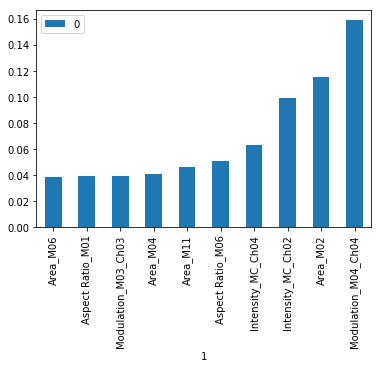

In [17]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # young =1 old = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=10, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))
print('Cross-validation Variance: ' + str(np.var(s)))

# Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
df = pd.DataFrame(list(zip(values,names))).set_index(1)

df.plot.bar()


### Without Ch 1, 6, 9

Feature Importances:
Modulation_M04_Ch04 0.166
Area_M02 0.132
Intensity_MC_Ch02 0.116
Intensity_MC_Ch04 0.088
Area_M11 0.067
Modulation_M03_Ch03 0.060
Area_M04 0.055
Modulation_M02_Ch02 0.051
Area_M03 0.049
Modulation_M07_Ch07 0.047
Cross-validation Score: 0.706270114152


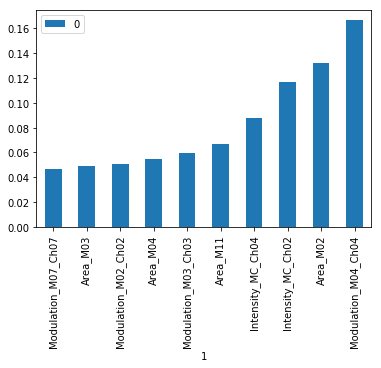

In [18]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # young =1 old = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
X = X.drop([i for i in X.columns if "01" in i] , axis=1)
X = X.drop([i for i in X.columns if "09" in i] , axis=1)
X = X.drop([i for i in X.columns if "06" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))

# Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())

df = pd.DataFrame(list(zip(values,names))).set_index(1)

df.plot.bar()


## What features predict ch11 and ch4 activation? Both are Klotho but different forms of it. 

### Ch11

Feature Importances:
Area_M09 0.191
Intensity_MC_Ch07 0.108
Area_M04 0.037
Intensity_MC_Ch02 0.035
Area_M01 0.027
Modulation_M07_Ch07 0.021
Area_M02 0.004
Area_M03 0.000
Modulation_M03_Ch03 0.000
Area_M01 0.000
Cross-validation Score: -2.36820211632
Cross-validation Score Var: 1.49174097503


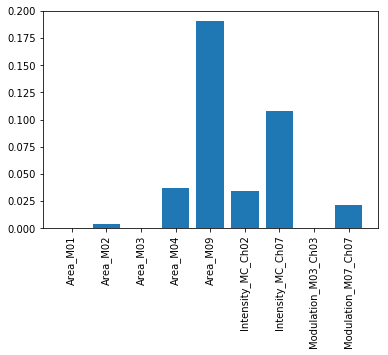

In [7]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Intensity_MC_Ch11.to_numpy()
# Y = Y>0 # ch11> = 1, ch11< = 0
# print(np.count_nonzero(Y))
X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
X = X.drop([i for i in X.columns if "Aspect Ratio_M02" in i] , axis=1)
# X = X.drop([i for i in X.columns if "09" in i] , axis=1)
# X = X.drop([i for i in X.columns if "06" in i] , axis=1)
X = X.drop([i for i in X.columns if "11" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
# clf = DecisionTreeClassifier(criterion='entropy')
reg = LinearRegression()
sol = reg.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.coef_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(reg, X.to_numpy(), Y.astype('int'), cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print('Cross-validation Score: ' + str(np.mean(s)))
print('Cross-validation Score Var: ' + str(np.var(s)))

# # Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
plt.figure()
plt.bar(names, values)
plt.xticks(rotation=90)
plt.show()

### Ch04

In [99]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Intensity_MC_Ch04.to_numpy()
# Y = Y>0 # ch04> = 1, ch04< = 0
X = new_db.drop(['Class', 'Object Number',], axis=1)
X = X.drop([i for i in X.columns if "Bkgd Mean" in i] , axis=1)
X = X.drop([i for i in X.columns if "Ch01" in i] , axis=1)
X = X.drop([i for i in X.columns if "Ch09" in i] , axis=1)
X = X.drop([i for i in X.columns if "Ch06" in i] , axis=1)
X = X.drop([i for i in X.columns if "Ch04" in i] , axis=1)

#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# # train a classifier on all the data
# clf = DecisionTreeClassifier(criterion='entropy')
# sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
reg = LinearRegression()
sol = reg.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.coef_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(reg, X.to_numpy(), Y.astype('int'), cv=10, n_jobs=-1, scoring='neg_mean_squared_error')
print('Cross-validation Score: ' + str(np.mean(s)))
print('Cross-validation Score Var: ' + str(np.var(s)))

# # Plot a graph with all the features
# sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
# names = list(sorted_d.keys())
# values = list(sorted_d.values())
# plt.figure()
# plt.bar(names, values)
# plt.xticks(rotation=90)
# plt.show()

Feature Importances:
Aspect Ratio_M11 223.313
Aspect Ratio_M02 201.002
Aspect Ratio_M07 96.948
Modulation_M11_Ch11 52.846
Aspect Ratio_M01 40.923
Area_M11 30.567
Intensity_MC_Ch02 19.980
Modulation_M07_Ch07 12.232
Aspect Ratio_M04 10.170
Area_M09 8.491
Cross-validation Score: -77854.1155397
Cross-validation Score Var: 48178074.5246


## Correlation between ch7 and ch11. 

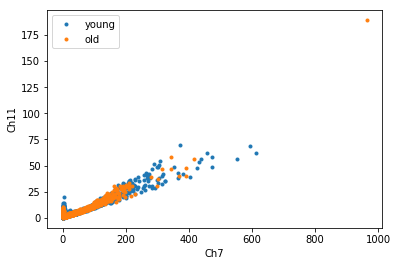

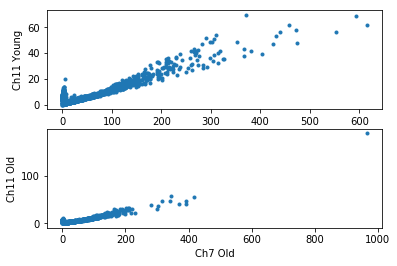

Young Pearson's correlation coefficient
[[ 1.         0.9190545]
 [ 0.9190545  1.       ]]
Old Pearson's correlation coefficient
[[ 1.          0.94859944]
 [ 0.94859944  1.        ]]


In [8]:
new_db = filtered_db
plt.figure()
young_ch7_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch07
young_ch11_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch11
old_ch7_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch07
old_ch11_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch11

plt.plot(young_ch7_intensity, young_ch11_intensity, '.')
plt.plot(old_ch7_intensity, old_ch11_intensity,'.')
plt.legend(['young', 'old'])
plt.xlabel('Ch7')
plt.ylabel('Ch11')
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch7_intensity, young_ch11_intensity, '.')
plt.xlabel('Ch7 Young')
plt.ylabel('Ch11 Young')
plt.subplot(2,1,2)
plt.plot(old_ch7_intensity, old_ch11_intensity,'.')
plt.xlabel('Ch7 Old')
plt.ylabel('Ch11 Old')
# plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch7_intensity, young_ch11_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch7_intensity, old_ch11_intensity))


### Let's try and run ransac on this example

In [ ]:
from ransac import *
X = young_ch7_intensity.to_numpy()/1000.0
Y = young_ch11_intensity.to_numpy()/1000.0
while X.shape[0]>20:
    inliers,model = ransac(X,Y)
    a,b,c = model
    print('slope:' + str(-b/a))
    X = X[inliers.flatten()<=0]
    Y = Y[inliers.flatten()<=0]
    if X.shape[0] <20:
        continue


In [ ]:
print(X.shape)

X = X[inliers.flatten()>0,...]
X.shape

## Correlation between ch7 and ch4. 

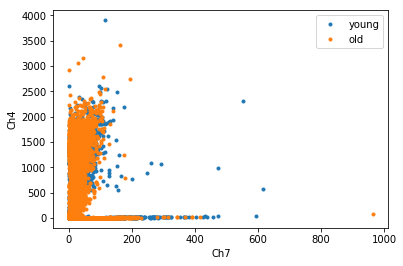

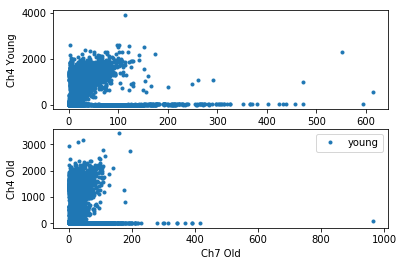

Young Pearson's correlation coefficient
[[ 1.         -0.09911957]
 [-0.09911957  1.        ]]
Old Pearson's correlation coefficient
[[ 1.         -0.04519945]
 [-0.04519945  1.        ]]


In [60]:
new_db = filtered_db
plt.figure()
young_ch7_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch07
young_ch4_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch04
old_ch7_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch07
old_ch4_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch04

plt.plot(young_ch7_intensity, young_ch4_intensity, '.')
plt.plot(old_ch7_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch7')
plt.ylabel('Ch4')
plt.legend(['young', 'old'])
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch7_intensity, young_ch4_intensity, '.')
plt.xlabel('Ch7 Young')
plt.ylabel('Ch4 Young')
plt.subplot(2,1,2)
plt.plot(old_ch7_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch7 Old')
plt.ylabel('Ch4 Old')
plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch7_intensity, young_ch4_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch7_intensity, old_ch4_intensity))


## Correlation between ch2 and ch11. 

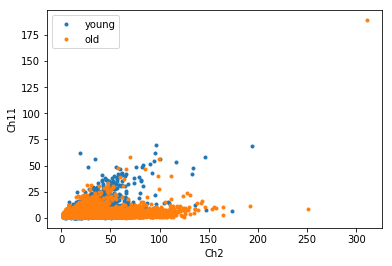

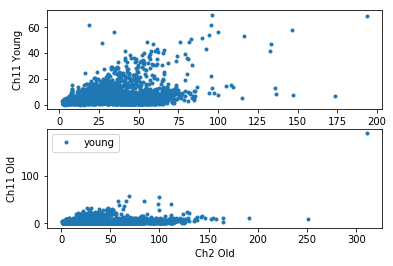

Young Pearson's correlation coefficient
[[ 1.          0.25892624]
 [ 0.25892624  1.        ]]
Old Pearson's correlation coefficient
[[ 1.          0.19495225]
 [ 0.19495225  1.        ]]


In [61]:
new_db = filtered_db
plt.figure()
young_ch2_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch02
young_ch11_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch11
old_ch2_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch02
old_ch11_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch11

plt.plot(young_ch2_intensity, young_ch11_intensity, '.')
plt.plot(old_ch2_intensity, old_ch11_intensity,'.')
plt.xlabel('Ch2')
plt.ylabel('Ch11')
plt.legend(['young', 'old'])
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch2_intensity, young_ch11_intensity, '.')
plt.xlabel('Ch2 Young')
plt.ylabel('Ch11 Young')
plt.subplot(2,1,2)
plt.plot(old_ch2_intensity, old_ch11_intensity,'.')
plt.xlabel('Ch2 Old')
plt.ylabel('Ch11 Old')
plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch2_intensity, young_ch11_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch2_intensity, old_ch11_intensity))

## Correlation between ch2 and ch4. 

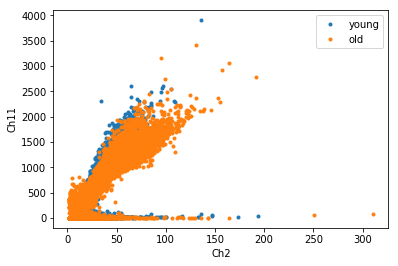

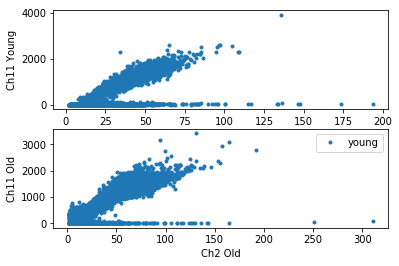

Young Pearson's correlation coefficient
[[ 1.          0.72379143]
 [ 0.72379143  1.        ]]
Old Pearson's correlation coefficient
[[ 1.          0.83691456]
 [ 0.83691456  1.        ]]


In [62]:
new_db = filtered_db
plt.figure()
young_ch2_intensity = new_db[(new_db.Class ==1)].Intensity_MC_Ch02
young_ch4_intensity = new_db[(new_db.Class==1)].Intensity_MC_Ch04
old_ch2_intensity = new_db[(new_db.Class ==0)].Intensity_MC_Ch02
old_ch4_intensity = new_db[(new_db.Class==0)].Intensity_MC_Ch04

plt.plot(young_ch2_intensity, young_ch4_intensity, '.')
plt.plot(old_ch2_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch2')
plt.ylabel('Ch11')
plt.legend(['young', 'old'])
plt.show()
# thought I should sperate these plots out. 
plt.subplot(2,1,1)
plt.plot(young_ch2_intensity, young_ch4_intensity, '.')
plt.xlabel('Ch2 Young')
plt.ylabel('Ch11 Young')
plt.subplot(2,1,2)
plt.plot(old_ch2_intensity, old_ch4_intensity,'.')
plt.xlabel('Ch2 Old')
plt.ylabel('Ch11 Old')
plt.legend(['young', 'old'])
plt.show()
# Pearson's correlation coefficient
print("Young Pearson's correlation coefficient")
print(np.corrcoef(young_ch2_intensity, young_ch4_intensity))
print("Old Pearson's correlation coefficient")
print(np.corrcoef(old_ch2_intensity, old_ch4_intensity))

## Ransac to do a line fit for the correlations ? 

## Differences in cd81, cd63 between young and old. 
Generated using code written by Ankit

In [63]:
analysis.getContingencyMatrix()

('Number of Young samples:', 6506)
('Number of Old Samples:', 6700)


,Young,Old
CD63+,4143.0,4606.0
CD63-,2363.0,2094.0


('p-value:', 7.7987562266608886e-10)


,Young,Old
CD81+,5918.0,6492.0
CD81-,588.0,208.0


('p-value:', 5.5074558972297418e-48)


,Young,Old
CD9+,5941.0,6556.0
CD9-,565.0,144.0


('p-value:', 6.3540173062570232e-66)


Old
Intensity CD63
Mean: 36.65 Variance: 716.47
Intensity CD81
Mean: 28.80 Variance: 989.29
Intensity KL
Mean: 3.72 Variance: 17.87
Size CD63
Mean: 734.95 Variance: 351150.86
Size CD81
Mean: 26.39 Variance: 4627.64
Size KL
Mean: 34.91 Variance: 19534.90
Young
Intensity CD63
Mean: 33.06 Variance: 246.56
Intensity CD81
Mean: 31.95 Variance: 1825.99
Intensity KL
Mean: 4.48 Variance: 28.21
Size CD63
Mean: 767.49 Variance: 281175.65
Size CD81
Mean: 49.25 Variance: 13295.78
Size KL
Mean: 98.37 Variance: 86784.15


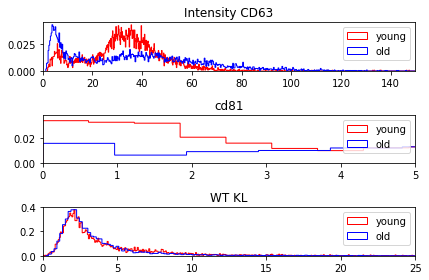

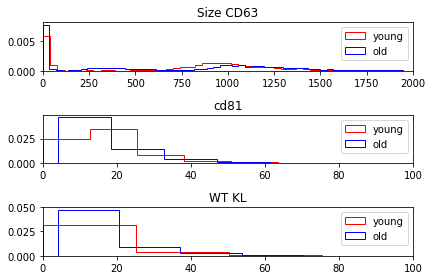

In [72]:
hist_range = [[0,150],[0,5],[0,25],[0,2000],[0,100],[0,100]]
# hist_range = []
dist = analysis.getTotalIntensityDistribution(hist_range)

labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Size CD63', 'Size CD81', 'Size KL']
for key in dist:
    print (key)
    for i,label in enumerate(labels):
        print(label)
        print('Mean: {0:.2f} Variance: {1:.2f}'.format(dist[key]['Mean'][i],dist[key]['Var'][i]))

In [65]:
points_young = analysis.points_young
points_old = analysis.points_old

from scipy.stats import mannwhitneyu
print ('Mann Whitney U Test Resuts:')
labels = ['Intensity CD63', 'Intensity CD81', 'Intensity KL','Size CD63', 'Size CD81', 'Size KL']
for i in range(0,6):
    young = points_young[:,i]
    old = points_old[:,i]
    print(labels[i] + ': ' +  str(mannwhitneyu(young, old)[1]))


Mann Whitney U Test Resuts:
Intensity CD63: 9.88781882134e-05
Intensity CD81: 0.00413062397832
Intensity KL: 1.0683569516e-10
Size CD63: 0.0113627984223
Size CD81: 9.82786696749e-34
Size KL: 2.65982986978e-41


## What happens if we keep all background mean features:

Feature Importances:
Modulation_M04_Ch04 0.145
Area_M02 0.112
Intensity_MC_Ch02 0.081
Intensity_MC_Ch04 0.062
Aspect Ratio_M06 0.044
Area_M11 0.036
Aspect Ratio_M11 0.034
Aspect Ratio_M01 0.033
Intensity_MC_Ch07 0.032
Area_M04 0.032
Cross-validation Score: 0.711644890662


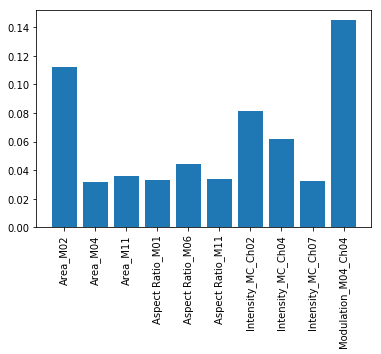

In [66]:
new_db = filtered_db
#When I was calling this function, it wasn't actually doing anything. No wonder we were getting 
#such crappy accuracies. 
new_db = new_db.sample(frac=1)

# Create the outputs Class 
Y = new_db.Class.to_numpy()
Y = Y>0 # ch04> = 1, ch04< = 0

X = new_db.drop(['Class', 'Object Number',], axis=1)


#This should drop nothing. 
X = X.drop(X.columns[X.isna().any()].tolist(), axis=1)

# train a classifier on all the data
clf = DecisionTreeClassifier(criterion='entropy')
sol = clf.fit(X.to_numpy(),Y.astype('int'))

# Print out the feature importances
print('Feature Importances:')
imp = sol.feature_importances_
features = {}
for i in range(0,10):
    print(X.columns[np.argmax(imp)] + ' ' + '{:0.3f}'.format(np.max(imp)))
    features[X.columns[np.argmax(imp)]] = np.max(imp)
    imp[np.argmax(imp)] = 0
    
# Print the crossvalidation score:
s = cross_val_score(clf, X.to_numpy(), Y.astype('int'), cv=20, n_jobs=-1)
print('Cross-validation Score: ' + str(np.mean(s)))

# Plot a graph with all the features
sorted_d = OrderedDict(sorted(features.items(), key=lambda x: x[1]))
names = list(sorted_d.keys())
values = list(sorted_d.values())
plt.figure()
plt.bar(names, values)
plt.xticks(rotation=90)
plt.show()

## Is there a way to find out if most of ch11 is >0 in cells that are ch2<0 and ch7>0

In [69]:
new_db = filtered_db
new_db = new_db[(new_db.Intensity_MC_Ch02 <0) & (new_db.Intensity_MC_Ch07>0)]
print('So what are we left with:', str(new_db.shape))
ch11 = new_db.Intensity_MC_Ch11
print('Ch11 positive:', np.count_nonzero(ch11>0))
print('Ch11 negative:', np.count_nonzero(ch11<=0))

('So what are we left with:', '(0, 27)')
('Ch11 positive:', 0)
('Ch11 negative:', 0)


## Using your method...if we do correlation between cd63 and KL or cd81 and KL.  Do we see the same thing?
### CD81 & KL

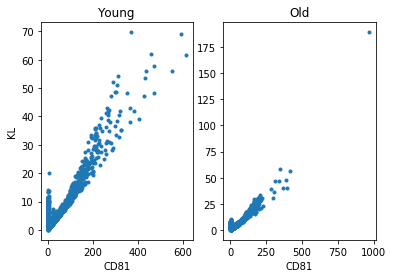

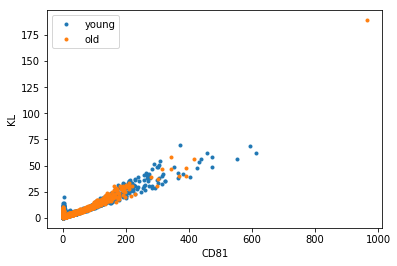

In [70]:
points_young = analysis.points_young
points_old = analysis.points_old
# points_young[:,1]
plt.subplot(1,2,1)
plt.title('Young')
plt.plot(points_young[:,1], points_young[:,2],'.')
plt.xlabel('CD81')
plt.ylabel('KL')

plt.subplot(1,2,2)
plt.title('Old')
plt.plot(points_old[:,1], points_old[:,2],'.')
plt.xlabel('CD81')
plt.figure()
plt.plot(points_young[:,1], points_young[:,2],'.')
plt.plot(points_old[:,1], points_old[:,2],'.')
plt.xlabel('CD81')
plt.ylabel('KL')
plt.legend(['young', 'old'])
plt.show()

### CD63 and KL

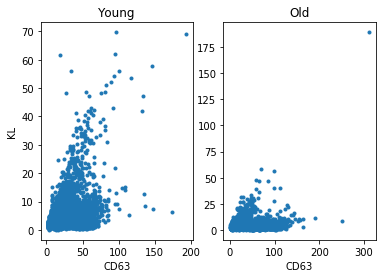

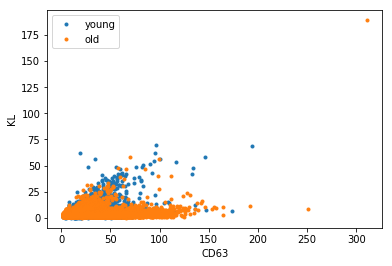

In [71]:
points_young = analysis.points_young
points_old = analysis.points_old
# points_young[:,1]
plt.subplot(1,2,1)
plt.title('Young')
plt.plot(points_young[:,0], points_young[:,2],'.')
plt.xlabel('CD63')
plt.ylabel('KL')

plt.subplot(1,2,2)
plt.title('Old')
plt.plot(points_old[:,0], points_old[:,2],'.')
plt.xlabel('CD63')
plt.figure()
plt.plot(points_young[:,0], points_young[:,2],'.')
plt.plot(points_old[:,0], points_old[:,2],'.')
plt.xlabel('CD63')
plt.ylabel('KL')
plt.legend(['young', 'old'])